In [1]:
import numpy as np
import pandas as pd

import cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
import matplotlib.font_manager as mfm

In [2]:
# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

matplotlib.backends.backend_pdf 3.0.3
numpy                           1.15.4
watermark                       1.8.1
pandas                          0.23.4
cartopy                         0.17.0
matplotlib                      3.0.3
ELEANOR LUTZ 2019-07-26 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit


In [3]:
'''
Declare global variables to use for every map
'''

figsize = (20, 10)
figsize_small = (10, 10)

starcolor = '#10112d'
basecolor = '#ffffff' # background color of the map 

# Mark the languages to use for the variable star symbol (prop_seguihis),
# Chinese asterism names (prop_chinese) and Chinese star names (prop_chinese_thin)
# With help from the code from the tutorial at this link:
# https://jdhao.github.io/2018/04/08/matplotlib-unicode-character/
prop_seguihis = mfm.FontProperties(fname='C:\WINDOWS\Fonts\seguihis.ttf')
prop_chinese = mfm.FontProperties(fname='C:\WINDOWS\Fonts\msyhbd.ttc')
prop_chinese_thin = mfm.FontProperties(fname='C:\WINDOWS\Fonts\msyh.ttc')

# The default cartopy projections don't interpolate with enough middle values 
# between constellation lines. This causes the lines to appear as a blocky
# polygon rather than smooth vectors. 
# Here I'm extending each projection class to use a lower interpolation threshold.
class LowerThresholdPlateCarree(ccrs.PlateCarree):
    ''' Add a new class to increase resolution of Geodetic vectors '''
    @property
    def threshold(self):
        return 0.01
    
class LowerThresholdOrtho(ccrs.Orthographic):
    ''' Add a new class to increase resolution of Geodetic vectors '''
    @property
    def threshold(self):
        return 0.1

In [4]:
def set_save_image(fig, savename, dpi=1200, show=True):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        try:
            ax.outline_patch.set_edgecolor('none')
            ax.background_patch.set_fill(False)
            ax.set_global()
        except:
            pass 
        
    # Remove all padding and margins
    plt.tight_layout()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)

    if show == True:
        plt.show()
    plt.clf()
    plt.close('all')
    
def add_vec(vecs, sub1, colors):
    ''' Add vector to subplot '''
    if len(vecs[0]) > 0: 
        v = list(vecs[0])
        v = [ra_to_earth(x) for x in v]
        sub1.plot(v, vecs[1], lw=1, color=colors[0], 
                  alpha=alpha, zorder=1,  transform=ccrs.Geodetic())
            
def add_vec_shift(vecs, sub1, colors, k=0.245):
    ''' Add vector to subplot with shift for different cultures '''
    shift = k * len(colors) / 2
    assert len(vecs[0]) > 0

    x = list(vecs[0])
    x = [ra_to_earth(x) for x in x]
    y = list(vecs[1])
    
    if len(y) > 1: # Some asterisms in the database are single stars
        center_y1 = y[0]
        center_y2 = y[1]

        lower_y1 = center_y1 - shift
        upper_y1 = center_y1 + shift
        lower_y2 = center_y2 - shift
        upper_y2 = center_y2 + shift
        range_y1 = upper_y1 - lower_y1
        range_y2 = upper_y2 - lower_y2

        y1_list = np.arange(lower_y1, upper_y1, range_y1 / len(colors))
        y2_list = np.arange(lower_y2, upper_y2, range_y2 / len(colors))
        zorder = 31 - len(colors)
        
        for y1, y2, c in zip(y1_list, y2_list, colors):
            ys = [y1, y2]
            sub1.plot(x, ys, lw=1, color=c, 
                      alpha=1, zorder=zorder,  transform=ccrs.Geodetic())

def ra_to_earth(val):
    ''' 
    Translate RA/DEC coordinates (in hours and degrees) 
    to the equivalent latitude/longitude so that Cartopy will plot correctly. 
    '''
    return 360-val*360/24

In [5]:
def plot_line_stars(savename, figsize, project, show=True, ortho=None):
    ''' Plot all of the asterisms and circles surrounding each star '''
    df_starcounts_single = pd.read_csv('./data/processed/starlist_cultures_design_single.csv')
    df_starpairs = pd.read_csv('./data/processed/star_pairs.csv')
    df_starcounts = pd.read_csv('./data/processed/starlist_cultures_design.csv')
    df_starcounts = df_starcounts[df_starcounts['count'] != 1]
    df_starcounts = df_starcounts.dropna()
    df_colormap = pd.read_csv("./data/processed/colormap.csv")
    
    if ortho == 90:
        df_starcounts = df_starcounts[df_starcounts['dec'] > 0]
        df_starcounts_single = df_starcounts_single[df_starcounts_single['dec'] > 0]
    elif ortho == -90:
        df_starcounts = df_starcounts[df_starcounts['dec'] < 0]
        df_starcounts_single = df_starcounts_single[df_starcounts_single['dec'] < 0]

    fig = plt.figure(figsize=figsize)
    sub1 = plt.axes(projection=project)
       
    # Manually fix missing null values (not ideal because J1991 is used but better than nothing)
    df_starcounts_single.loc[df_starcounts_single['star_ID'] == 115125, ['ra']] = 23+19/60+6.37/60/60
    df_starcounts_single.loc[df_starcounts_single['star_ID'] == 115125, ['dec']] = -13-27/60-17/60/60
    df_starcounts_single.loc[df_starcounts_single['star_ID'] == 59273, ['ra']] = 12+9/60+29.02/60/60
    df_starcounts_single.loc[df_starcounts_single['star_ID'] == 59273, ['dec']] = -11-51/60-15/60/60
    if df_starcounts_single.isnull().sum().sum() > 0:
        display(df_starcounts_single[pd.isnull(df_starcounts_single['ra']) | \
                                     pd.isnull(df_starcounts_single['dec'])])   
    df_starcounts_single.dropna(axis=0, inplace=True)
    df_starcounts_single['dec'].clip(lower=-180, upper=180, inplace=True) 
    df_starcounts_single['ra'].clip(lower=-90, upper=90, inplace=True)
    
    # All stars with just one culture should be plotted in that culture's color
    for name, group in df_starcounts_single.groupby('culture'):
        color = df_colormap[df_colormap['culture'] == name].iloc[0].color 
        sub1.scatter(360-group['ra']*360/24, group['dec'], 
                     s=group['size'], facecolors=basecolor, edgecolors=color, 
                     lw=1, zorder=2000, transform=ccrs.PlateCarree()) # background
        sub1.scatter(360-group['ra']*360/24, group['dec'], 
                     s=group['size'], facecolors='none', edgecolors=color, alpha=0.4, 
                     lw=1, zorder=2002, transform=ccrs.PlateCarree()) # border

    # All stars with multiple cultures should be plotted with a white circle 
    df_starcounts['zsize'] = df_starcounts['size'].max()-df_starcounts['size']
    df_starcounts['dec'].clip(lower=-180, upper=180, inplace=True) 
    df_starcounts['ra'].clip(lower=-90, upper=90, inplace=True)
    if df_starcounts.isnull().sum().sum() > 0:
        display(df_starcounts[pd.isnull(df_starcounts['ra']) | pd.isnull(df_starcounts['dec'])])
        df_starcounts.dropna(axis=0, inplace=True)
    for z, group in df_starcounts.groupby('zsize'):
        sub1.scatter(360-group['ra']*360/24, group['dec'], 
                     s=group['size'], facecolors=basecolor, edgecolors=basecolor, 
                     lw=1, zorder=z, transform=ccrs.PlateCarree()) # background
        sub1.scatter(360-group['ra']*360/24, group['dec'], 
                     s=group['size'], facecolors='none', edgecolors=starcolor, alpha=0.5, 
                     lw=1, zorder=z+1, transform=ccrs.PlateCarree()) # border
        sub1.scatter(360-group['ra']*360/24, group['dec'], 
                     s=group['size'], facecolors='none', edgecolors=starcolor, alpha=0.25, 
                     lw=1, zorder=2001, transform=ccrs.PlateCarree()) # border overlay
        
    ### ADD LINES ###
    unique_lines = df_starpairs['star_ID_pair'].unique()
    print(len(unique_lines), 'unique lines to plot')
    for unique in unique_lines:
        temp = df_starpairs[df_starpairs['star_ID_pair'] == unique]
        dec = temp.iloc[0].decs.replace(",", "").split()
        ra = temp.iloc[0].ras.replace(",", "").split()

        dec = [float(x) for x in dec if not np.isnan(float(x))]
        ra = [float(x) for x in ra if not np.isnan(float(x))]
        vecs = [ra, dec]

        if len(vecs[0]) > 2: 
            vecs_1 = [vecs[0][i:i+2] for i in range(0, len(vecs[0]), 2)]
            vecs_2 = [vecs[1][i:i+2] for i in range(0, len(vecs[1]), 2)] 
            vecs = [vecs_1, vecs_2]

        cultures = sorted(temp.culture.tolist())
        colors = [df_colormap[df_colormap.culture == culture].iloc[0].color for culture in cultures]
        add_vec_shift(vecs, sub1, colors)

    set_save_image(fig, savename, show=show)
    
def plot_stars(savename, figsize, project, show=True, ortho=None, varstar=True):
    ''' Plot the stars according to their magnitude '''
    stars = pd.read_csv('./data/processed/hygdata_processed_mag65.csv')

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=project)
    prop_seguihis = mfm.FontProperties(fname='C:\WINDOWS\Fonts\seguihis.ttf')

    stars_nonvar = stars[pd.isnull(stars['var'])]
    print(len(stars_nonvar), 'non-variable stars to plot')
    ax.scatter(360-stars_nonvar['ra']*360/24, stars_nonvar['dec'], transform=ccrs.Geodetic(),
               s=(6.5-stars_nonvar['mag'])*5, color=starcolor, lw=0, edgecolor='none')

    stars_var = stars[pd.notnull(stars['var'])]
    if ortho == 90:
        stars_var = stars_var[stars_var['dec'] > 0]
    if ortho == -90:
        stars_var = stars_var[stars_var['dec'] < 0]
        
    if varstar == True:
        print(len(stars_var), 'variable stars to overplot')
        for index, row in stars_var.iterrows(): 
            # subtract -0.25 from dec for Plate Carree to offset font issues
            ax.text(ra_to_earth(row['ra']), row['dec'], u"\u16BC", transform=ccrs.PlateCarree(),
                    fontproperties=prop_seguihis, fontsize=(12-row['mag']), 
                    alpha=0.75, color=starcolor, ha='center', va='center')

    set_save_image(fig, savename, show=show)
    
def plot_gridlines(savename, figsize, project, c, show=True, ortho=False):
    ''' Plot gridlines for the map '''
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=project)

    lon_large = np.arange(-180, 181-ortho, 1*360/24)
    lon_small = np.arange(-180, 181-ortho, 0.5*360/24)
    lat_large = np.arange(-90, 91-ortho, 10)
    lat_small = np.arange(-90, 91-ortho, 5)
    lat_delim = np.arange(-90, 90.01-ortho/100, 0.1)
    lon_delim = np.arange(-180, 180.01-ortho/100, 0.1)

    for lg in lat_large: 
        ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), 
                color=c, lw=0.25, alpha=0.25, clip_on=False)
    for sm in lat_small: 
        if sm not in lat_large: 
            ax.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), 
                    color=c, lw=0.125, alpha=0.25, clip_on=False)
    for lg in lon_large: 
        ax.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
                color=c, lw=0.25, alpha=0.25, clip_on=False)
    for sm in lon_small: 
        if sm not in lon_large: 
            ax.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
                    color=c, lw=0.125, alpha=0.25, clip_on=False)

    set_save_image(fig, savename, show=show)

3645 unique lines to plot


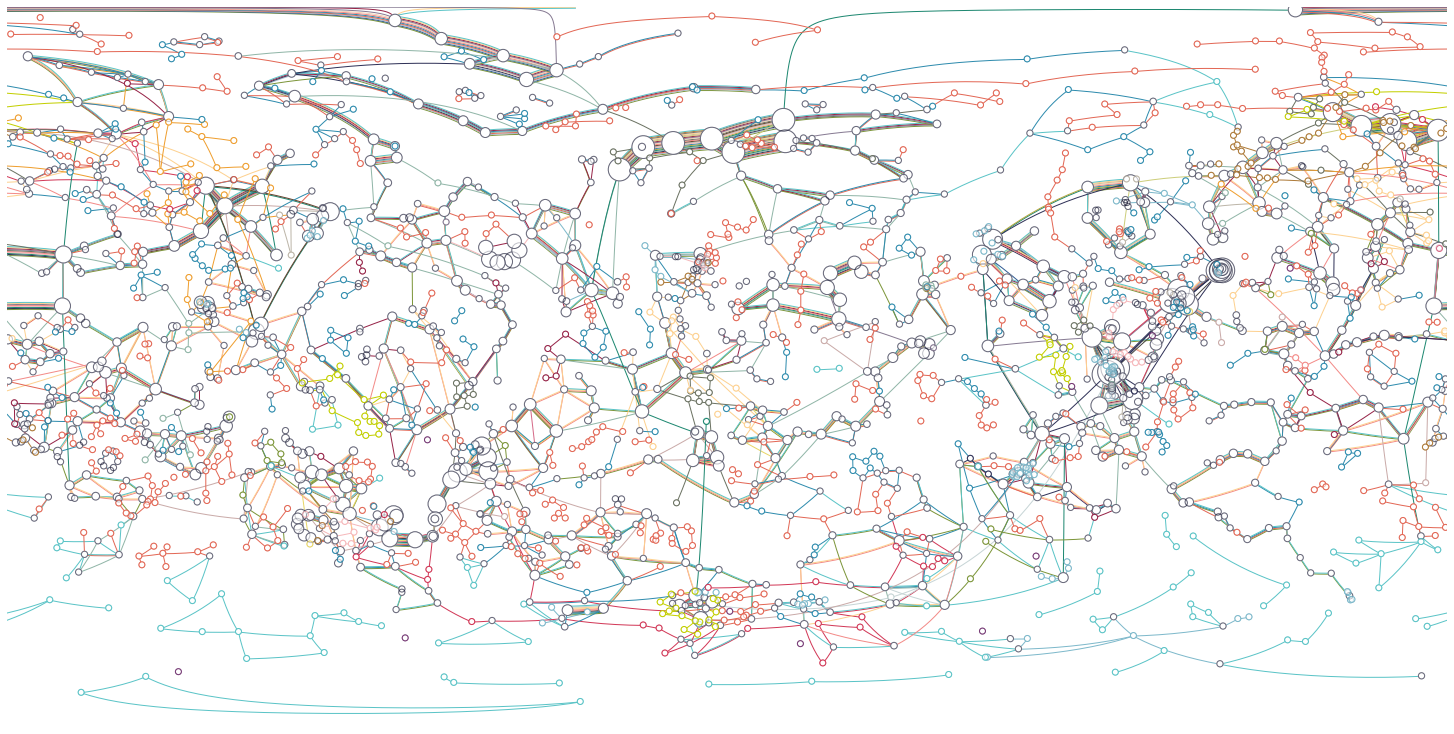

7723 non-variable stars to plot
1189 variable stars to overplot


In [ ]:
# Plot the asterisms, stars, and gridlines for the main Plate Carree projection map

project = LowerThresholdPlateCarree(180)
plot_line_stars('./figures/asterisms_all_cultures.png', figsize, project)
plot_stars('./figures/star_fills.png', figsize, project, show=False)

project = ccrs.PlateCarree()
plot_gridlines('./figures/gridlines.png', figsize, project, c=starcolor, show=False)

3645 unique lines to plot


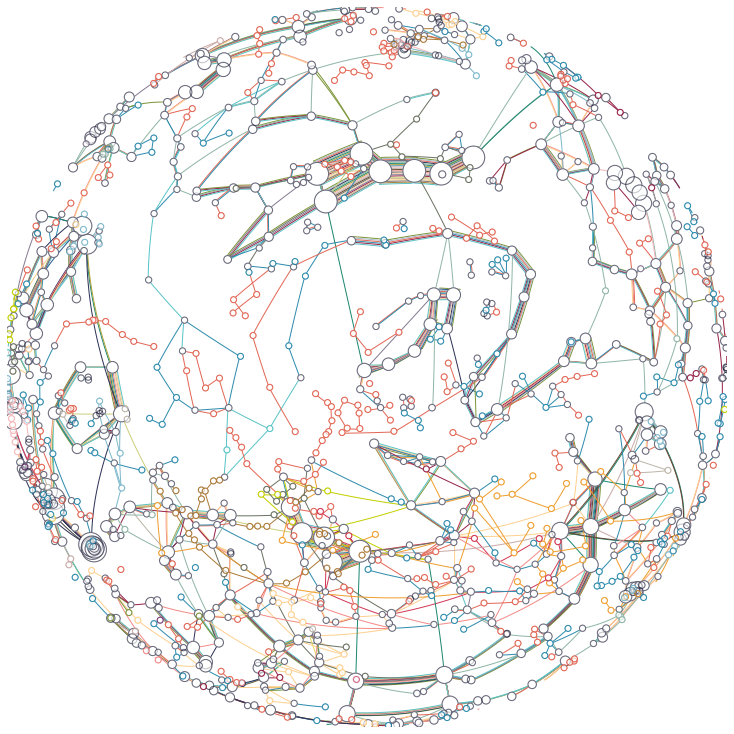

7723 non-variable stars to plot
581 variable stars to overplot
3645 unique lines to plot


In [ ]:
# Plot the asterisms, stars, and gridlines for the Orthographic projections (North and South poles)

project = LowerThresholdOrtho(0, 90)
plot_line_stars('./figures/northpole_lines.png', figsize_small, project, ortho=90)
plot_stars('./figures/northpole_stars.png', figsize_small, project, ortho=90, show=False)
plot_gridlines('./figures/northpole_grid.png', figsize_small, project, c=starcolor, show=False, ortho=True)

project = LowerThresholdOrtho(0, -90)
plot_line_stars('./figures/southpole_lines.png', figsize_small, project, ortho=-90, show=False)
plot_stars('./figures/southpole_stars.png', figsize_small, project, ortho=-90, show=False)
plot_gridlines('./figures/southpole_grid.png', figsize_small, project, c=starcolor, show=False, ortho=True)

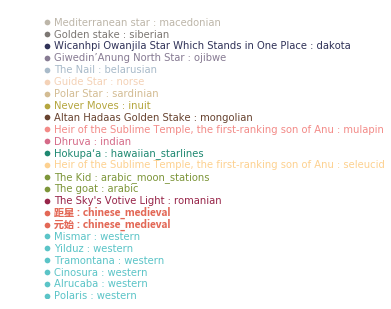

In [6]:
# Plot each culture's name for Star ID 11767 (North pole star) in the correct color
# (Used for reference in designing the map, not used directly in the design)

df = pd.read_csv('./data/processed/named_stars_to_plot.csv', encoding="utf-8")

stars = [11767] # polaris 
for star in stars: 
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)

    temp = df[df['star'] == star]
    temp.reset_index(inplace=True)
    for index, row in temp.iterrows(): 
        ax.scatter(0.5, index/2, s=6.5*5, lw=0, color=row['color'])
        if row['culture'] != 'chinese_medieval':
            ax.text(0.6, index/2, row['name']+' : '+row['culture'], ha='left', va='center', color=row['color'])
        else:
            ax.text(0.6, index/2, row['name']+' : '+row['culture'], fontproperties=prop_chinese, 
                    ha='left', va='center', color=row['color'])
    ax.set_xlim(0, 4)
    ax.set_ylim(-0.1, 12)
    set_save_image(fig, './figures/'+str(star)+'_star_names.pdf', show=True)

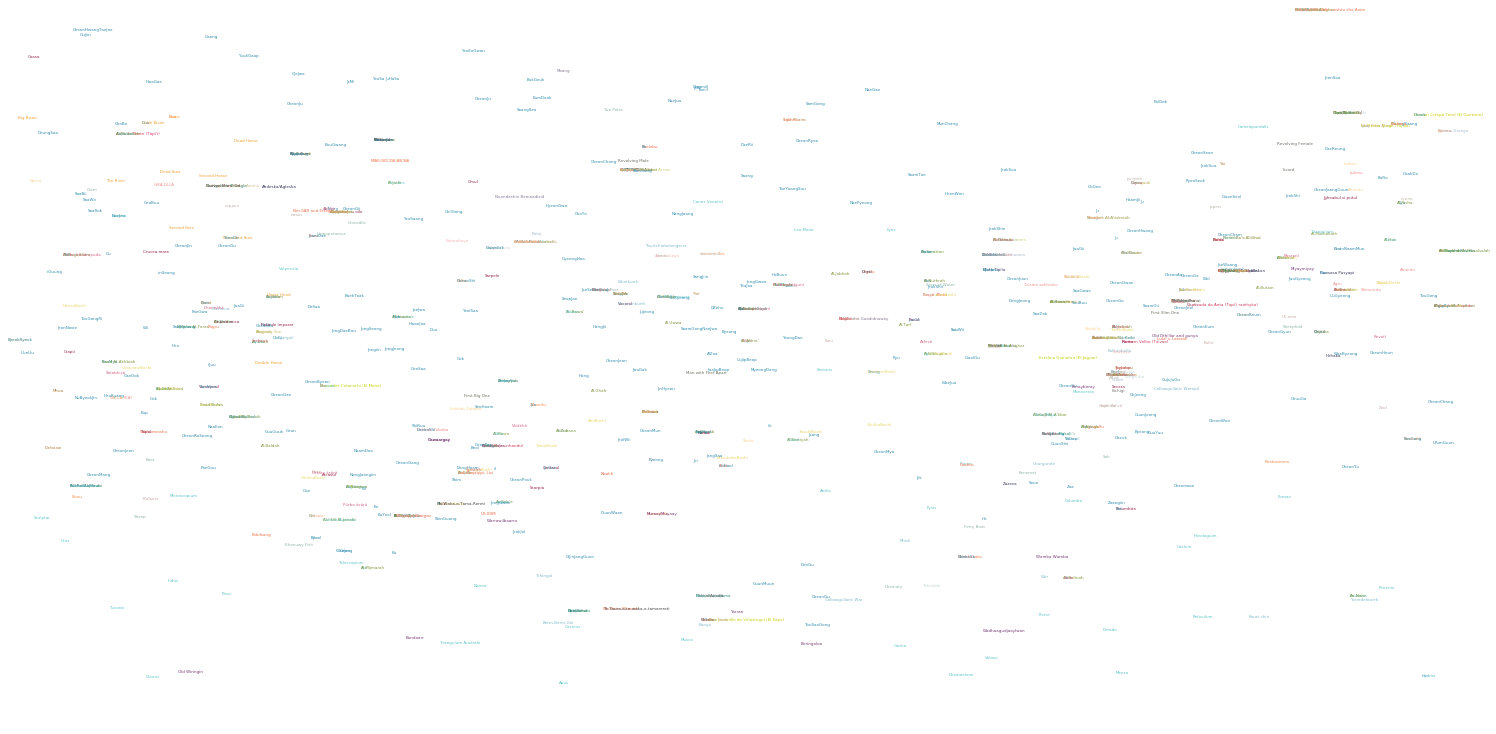

In [7]:
# Plot the names of each of the asterisms in all languages except Chinese

const_names = pd.read_csv('./data/processed/named_asterisms_to_plot.csv', encoding="utf-8")

non_ch = const_names[const_names['culture'] != 'chinese_medieval']
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.background_patch.set_fill(False)
for index, row in non_ch.iterrows(): 
    ax.text(ra_to_earth(row['ra']), row['dec'], row['name'], 
            transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=4, color=row['color'])
set_save_image(fig, './figures/constellation_names.pdf', show=True)

####################################################################################################

# Plot the names of the Chinese asterisms using a different font

ch = const_names[const_names['culture'] == 'chinese_medieval']
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.background_patch.set_fill(False)
for index, row in ch.iterrows(): 
    ax.text(ra_to_earth(row['ra']), row['dec'], row['name'], fontproperties=prop_chinese,
            transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=4, color=row['color'])
set_save_image(fig, './figures/constellation_names_chinese.pdf', show=False)

In [8]:
# Plot the names of each of the stars (with only one name) in all languages except Chinese

const_names = pd.read_csv('./data/processed/named_asterisms_to_plot.csv', encoding="utf-8")
df = pd.read_csv('./data/processed/named_stars_to_plot.csv', encoding="utf-8")
df_singles = df.drop_duplicates('star', keep=False)
print(len(df_singles), 'star names that belong to single cultures')

non_ch = df_singles[df_singles['culture'] != 'chinese_medieval']
print(len(non_ch), 'total star names')
display(non_ch[~non_ch['name'].isin(list(non_ch['name'].drop_duplicates(keep=False)))])
non_ch = non_ch.drop_duplicates(subset='name', keep=False)
print(len(non_ch), 'non-duplicate star names')
non_ch = non_ch[~non_ch['name'].isin(const_names['name'].tolist())]
print(len(non_ch), 'non-duplicate star names that are not asterisms')
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.background_patch.set_fill(False)
for index, row in non_ch.iterrows(): 
    ax.text(ra_to_earth(row['ra']), row['dec'], row['name'], 
            transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=8, color=row['color'])    
set_save_image(fig, './figures/star_names_singles.pdf', show=False)

####################################################################################################

# Plot the names of the Chinese stars (with only one name) using a different font

ch = df_singles[df_singles['culture'] == 'chinese_medieval']
print(len(ch), 'total Chinese star names')
ch = ch.drop_duplicates(subset='name', keep=False)
print(len(ch), 'non-duplicate Chinese star names')
ch = ch[~ch['name'].isin(const_names['name'].tolist())]
print(len(ch), 'non-duplicate Chinese star names that are not asterisms')
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.background_patch.set_fill(False)
for index, row in ch.iterrows(): 
    ax.text(ra_to_earth(row['ra']), row['dec'], row['name'], fontproperties=prop_chinese_thin,
            transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=3.8, color=row['color'])    
set_save_image(fig, './figures/star_names_singles_chinese.pdf', show=False)

402 star names that belong to single cultures
206 total star names


,star,name,ra,dec,culture,total_culture_names,color
390,107418,Castula,21.757480,61.120806,western,876,#5bc4c7
462,4422,Castula,0.944432,59.181056,western,876,#5bc4c7
2302,61199,Quira-Rupia,12.541134,-72.132988,tupi,2,#d23958
2303,63613,Quira-Rupia,13.037759,-71.548855,tupi,2,#d23958


202 non-duplicate star names
200 non-duplicate star names that are not asterisms
196 total Chinese star names
49 non-duplicate Chinese star names
28 non-duplicate Chinese star names that are not asterisms


819 total stars
417 stars with more than one culture
417 non-duplicated stars with more than one culture
411 non-duplicate star names that are not asterisms


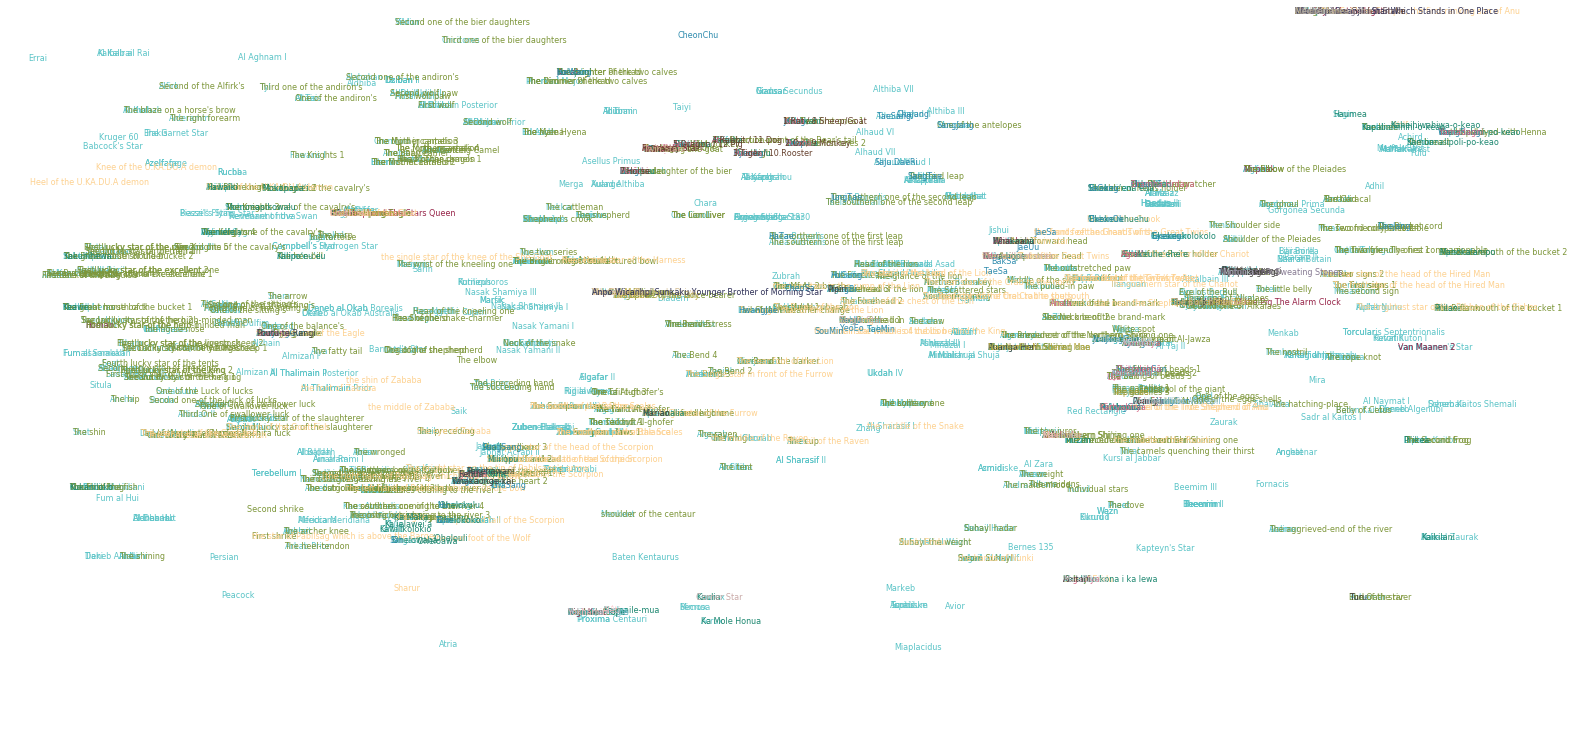

In [9]:
# Plot the names of each of the stars (with more than one name) in all languages
# There are so many Chinese labels already so I ignored Chinese labels for this subsection.

const_names = pd.read_csv('./data/processed/named_asterisms_to_plot.csv', encoding="utf-8")

df = pd.read_csv('./data/processed/named_stars_to_plot.csv', encoding="utf-8")
print(len(df['star'].unique()), 'total stars')
df_singles = df[~df['star'].isin(list(df['star'].drop_duplicates(keep=False)))]
print(len(df_singles['star'].unique()), 'stars with more than one culture')
non_ch = df_singles[df_singles['culture'] != 'chinese_medieval']
non_ch = non_ch.dropna()
non_ch = non_ch.drop_duplicates(subset='name')
print(len(df_singles['star'].unique()), 'non-duplicated stars with more than one culture')
non_ch = non_ch[~non_ch['name'].isin(const_names['name'].tolist())]
print(len(non_ch['star'].unique()), 'non-duplicate star names that are not asterisms')

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.background_patch.set_fill(False)
for index, row in non_ch.iterrows(): 
    ax.text(ra_to_earth(row['ra']), row['dec'], row['name'], 
            transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=8, color=row['color'])    
set_save_image(fig, './figures/star_names_multiples.pdf', show=True)

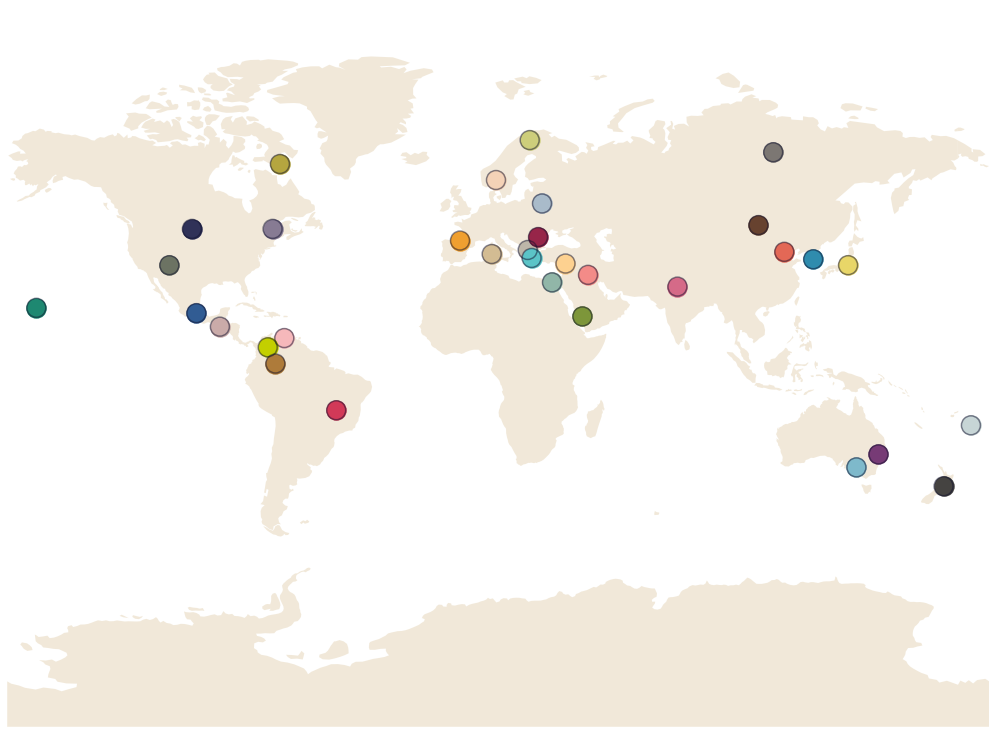

In [ ]:
# Plot the approximate "home location" of each culture on a vector map of the Earth

colors = pd.read_csv("./data/processed/colormap.csv")

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Miller(central_longitude=11.5))
ax.add_feature(cartopy.feature.LAND, facecolor='#e4d3b5', alpha=0.5, edgecolor="none")
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '110m')

for index, row in colors.iterrows(): 
    if row['culture'] not in ['arabic_moon_stations']: # Duplicate of arabic constellations
        ax.scatter(row['earth_EW'], row['earth_NS'], transform=ccrs.PlateCarree(), 
                   facecolor=row['color'], edgecolor=row['color'], s=360, 
                   alpha=1, lw=1.5, zorder=2)
        ax.scatter(row['earth_EW'], row['earth_NS'], transform=ccrs.PlateCarree(), 
                   facecolor='none', edgecolor=starcolor, s=360, 
                   alpha=0.5, lw=1.5, zorder=3)
    
set_save_image(fig, './figures/constellation_locations.pdf')

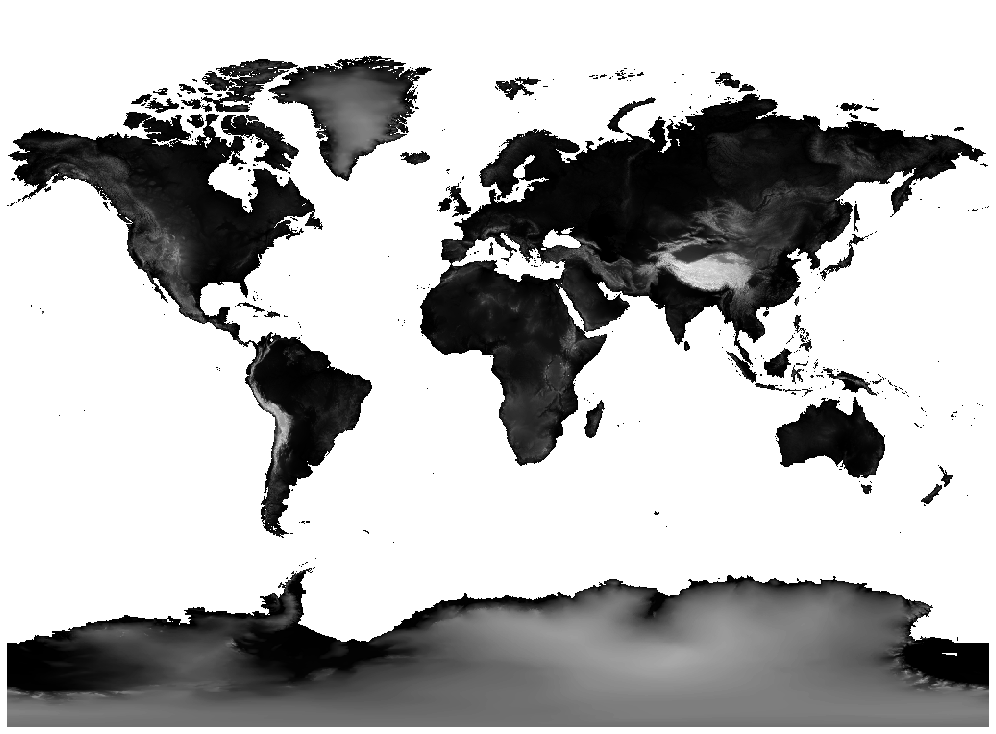

In [6]:
# Plot the raster dataset of Earth topography to use as an overlay on top 
# of the vector Earth map
# Land topography data from NASA NEO: 
# https://neo.sci.gsfc.nasa.gov/view.php?datasetId=SRTM_RAMP2_TOPO

topo = pd.read_csv("./data/SRTM_RAMP2_TOPO_2000-02-11_gs_3600x1800.CSV")
topo = topo.replace(to_replace=99999, value=np.nan)

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Miller(central_longitude=11.5))
ax.imshow(topo.values, origin="upper", cmap='gray',
          transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
    
set_save_image(fig, './figures/location_topo.png')

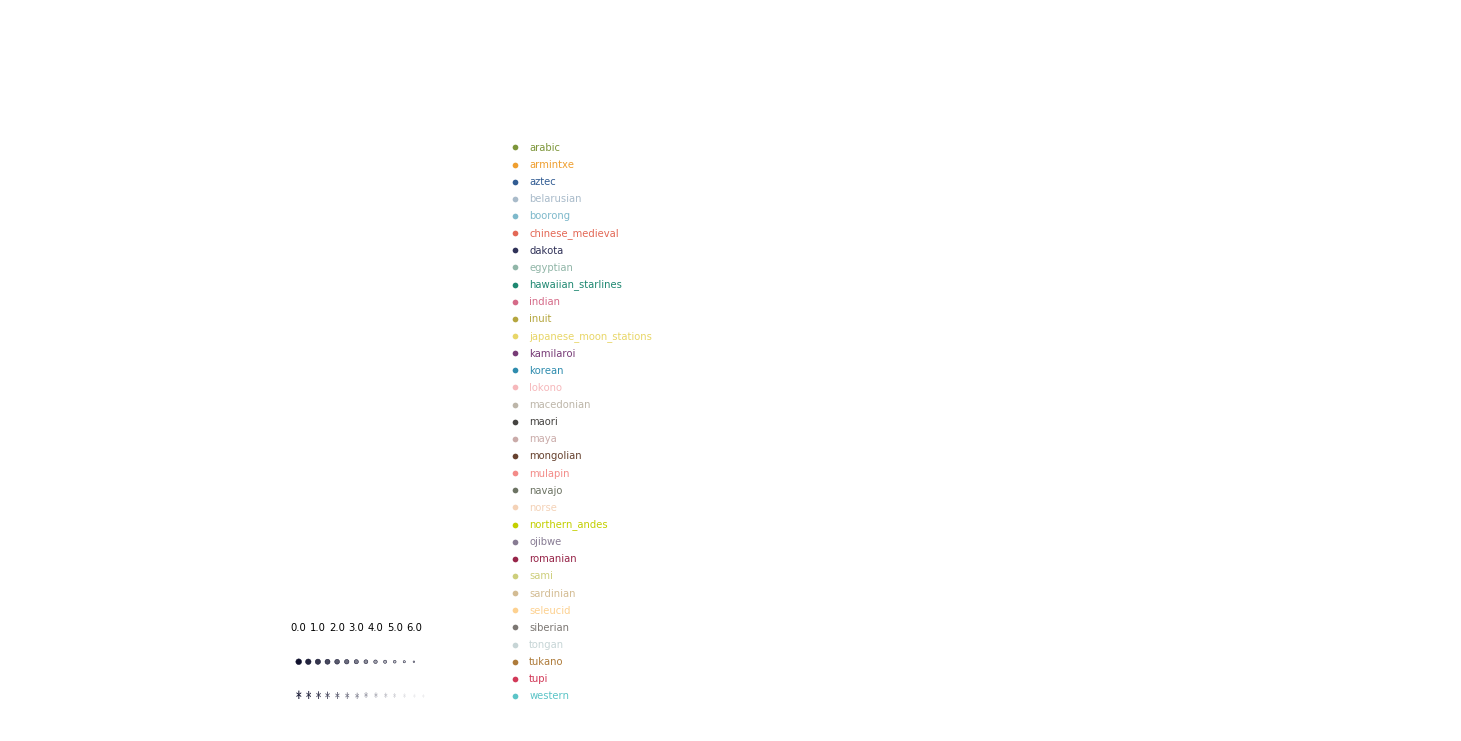

In [7]:
# Print a key of star sizes and culture colors
# (Not used directly in the main map, but used as a reference guide)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# Keys for star sizes
mags = np.arange(0, 6.55, 0.5)
for index, mag in enumerate(mags): 
    # Numbers
    if index % 2 == 0:
        ax.text(2+index/15, 2, mag, ha='center', va='center')
    
    # Key for variable star sizes
    ax.text(2+index/15, 0, u"\u16BC", fontproperties=prop_seguihis, fontsize=(12-mag), 
            alpha=max(0.1, min(1,((6.5-mag)*5)/(6.5*5))), color=starcolor, ha='center', va='center')

    # Key for normal star sizes
    ax.scatter(2+index/15, 1, s=(6.5-mag)*5, color=starcolor, lw=0, edgecolor='none', 
               alpha=min(1, ((6.5-mag)*5)/(6.5*5)))
    ax.scatter(2+index/15, 1, alpha=1, s=(6.5-mag)*5, edgecolor=starcolor, lw=0.5, facecolor='none')

# Key for colors
cols = pd.read_csv("./data/processed/colormap.csv")
cols.sort_values(by='culture', ascending=False, inplace=True)
cols = cols[cols['culture'] != 'arabic_moon_stations']
cols.reset_index(inplace=True)
for index, row in cols.iterrows(): 
    ax.scatter(3.5, index/2, s=6.5*5, lw=0, color=row['color'])
    ax.text(3.6, index/2, row['culture'], ha='left', va='center', color=row['color'])

ax.set_xlim(0, 10)
ax.set_ylim(-1, 20)
set_save_image(fig, './figures/key.pdf')

In [8]:
# Plot reference maps that only include one culture each, for troubleshooting. 
# This is also useful as a reference when labeling, because it's often unclear
# which other stars belong to the constellation (text label is only on one of the stars)
# Also print out the number of asterisms belonging to each culture, for information 

text = False

const_names = pd.read_csv('./data/processed/named_asterisms_to_plot.csv', encoding="utf-8")
df_starpairs = pd.read_csv('./data/processed/star_pairs.csv')
culturelist = df_starpairs['culture'].unique().tolist()[::-1]
df_colormap = pd.read_csv("./data/processed/colormap.csv")

for culture in culturelist: 
    names = const_names[const_names['culture'] == culture]
    starpairs = df_starpairs[df_starpairs['culture'] == culture]

    fig = plt.figure(figsize=figsize)
    sub1 = plt.axes(projection=ccrs.PlateCarree(180))

    unique_lines = starpairs['star_ID_pair'].tolist()
    for unique in unique_lines:
        temp = starpairs[starpairs['star_ID_pair'] == unique]
        cultures = sorted(temp.culture.tolist())
        colors = [df_colormap[df_colormap.culture == culture].iloc[0].color for culture in cultures]

        dec = temp.iloc[0].decs.replace(",", "").split()
        ra = temp.iloc[0].ras.replace(",", "").split()

        dec = [float(x) for x in dec if not np.isnan(float(x))]
        ra = [float(x) for x in ra if not np.isnan(float(x))]
        vecs = [ra, dec]
        sub1.scatter([ra_to_earth(val) for val in ra], dec, transform=ccrs.PlateCarree(), 
                     s=36, edgecolor=colors[0], facecolor=basecolor, zorder=100)

        if len(vecs[0]) > 2: 
            vecs_1 = [vecs[0][i:i+2] for i in range(0, len(vecs[0]), 2)]
            vecs_2 = [vecs[1][i:i+2] for i in range(0, len(vecs[1]), 2)] 
            vecs = [vecs_1, vecs_2]

        add_vec_shift(vecs, sub1, colors)

    if text == True:
        for index, row in names.iterrows(): 
            if culture != 'chinese_medieval':
                sub1.text(ra_to_earth(row['ra']), row['dec'], row['name'], zorder=100, 
                    transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=14, color='k')
            else: 
                sub1.text(ra_to_earth(row['ra']), row['dec'], row['name'], zorder=100, fontproperties=prop_chinese, 
                    transform=ccrs.PlateCarree(), ha='left', va='center', fontsize=14, color='k')
        sub1.set_title(culture, color=colors[0])
        
    print(culture, ":", len(names), 'asterisms')
    set_save_image(fig, savename= "figures/breakdown_"+culture+".png", show=False)

arabic : 49 asterisms
arabic_moon_stations : 28 asterisms
armintxe : 11 asterisms
aztec : 5 asterisms
belarusian : 20 asterisms
boorong : 29 asterisms
chinese_medieval : 339 asterisms
dakota : 13 asterisms
egyptian : 28 asterisms
hawaiian_starlines : 13 asterisms
indian : 28 asterisms
inuit : 11 asterisms
japanese_moon_stations : 28 asterisms
kamilaroi : 13 asterisms
korean : 272 asterisms
lokono : 11 asterisms
macedonian : 19 asterisms
maori : 6 asterisms
maya : 14 asterisms
mongolian : 4 asterisms
mulapin : 60 asterisms
navajo : 8 asterisms
norse : 6 asterisms
northern_andes : 5 asterisms
ojibwe : 10 asterisms
romanian : 39 asterisms
sami : 10 asterisms
sardinian : 11 asterisms
seleucid : 60 asterisms
siberian : 3 asterisms
tongan : 11 asterisms
tukano : 11 asterisms
tupi : 7 asterisms
western : 88 asterisms
